In [1]:
import keras
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

REMOVE_DUPLICATE_EEG_IDS = True # if True, each row in training corresponds to a unique eeg_id
AVERAGE_TARGETS_OVER_EEG = True
MAX_ROWS = None # use only MAX_ROWS rows of train.csv, set to None to use all rows
USE_CACHE = True # stores all accessed eeg and spectrogram files in memory

DATA_DIR = 'data' # /kaggle/input/hms-harmful-brain-activity-classification/

2024-02-21 07:28:23.229614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 07:28:23.229671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 07:28:23.249718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 07:28:23.300577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 07:28:24.091228: W tensorflow/compiler/tf2

In [2]:
train_csv = pd.read_csv(f'{DATA_DIR}/train.csv', dtype={'eeg_label_offset_seconds': 'int', 'spectrogram_label_offset_seconds': 'int'})
TARGETS = train_csv.columns[-6:]

def actual_median(s):
    return s.iloc[(s - s.median()).abs().argsort().iloc[0]]

if REMOVE_DUPLICATE_EEG_IDS:
    df_unique_eeg = train_csv.groupby('eeg_id')[['eeg_label_offset_seconds']].agg(actual_median)
    train_df = pd.merge(df_unique_eeg, train_csv, on=['eeg_id', 'eeg_label_offset_seconds'], how='left')
    
    if AVERAGE_TARGETS_OVER_EEG:
        y = train_csv.groupby('eeg_id')[TARGETS].agg('sum')
        y = y.div(y.sum(axis=1), axis=0)
        train_df[TARGETS] = y[TARGETS].values
else:
    train_df = train_csv

train_df = train_df[:MAX_ROWS]

train_df

,eeg_id,eeg_label_offset_seconds,eeg_sub_id,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,6,1,789577333,1,6,3640441665,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,18,5,1552638400,5,18,1179854295,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,0,0,14960202,12,1008,3254468733,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,0,0,618728447,4,908,2898467035,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,0,0,52296320,0,0,3255875127,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,0,0,1188113564,0,0,447244163,16610,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,0,0,1549502620,0,0,1618953053,15065,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,0,0,2105480289,0,0,469526364,56,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,6,2,657299228,2,6,3251917981,4312,Other,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [3]:
from functools import cache

def read_parquet(path):
    @cache
    def f(id_):
        return pd.read_parquet(f'{path}{id_}.parquet')
    return f

read_eeg_train = read_parquet(path=f'{DATA_DIR}/train_eegs/')
read_eeg_test = read_parquet(path=f'{DATA_DIR}/test_eegs/')
read_spg_train = read_parquet(path=f'{DATA_DIR}/train_spectrograms/')
read_spg_test = read_parquet(path=f'{DATA_DIR}/test_spectrograms/')

def eeg_window(row, train=True):
    eeg_data = read_eeg_train(row.eeg_id) if train else read_eeg_test(row.eeg_id)
    if train:
        eeg_offset = int(row.eeg_label_offset_seconds)
        eeg_data = eeg_data.iloc[(200 * eeg_offset):(200 * (eeg_offset + 50))]
    return eeg_data

def spg_window(row, train=True):
    spg_data = read_spg_train(row.spectrogram_id) if train else read_spg_test(row.spectrogram_id)
    if train:
        spg_offset = int(row.spectrogram_label_offset_seconds)
        spg_data = spg_data.loc[(spg_data.time >= spg_offset) & (spg_data.time < spg_offset + 600)]
        spg_data = spg_data.drop(columns=['time'])
    return spg_data

# spg_window(train_df.iloc[133])
# read_spg_train(train_df.iloc[14583].spectrogram_id).isna().any()
# train_df.iloc[133]

(100, 300, 4)

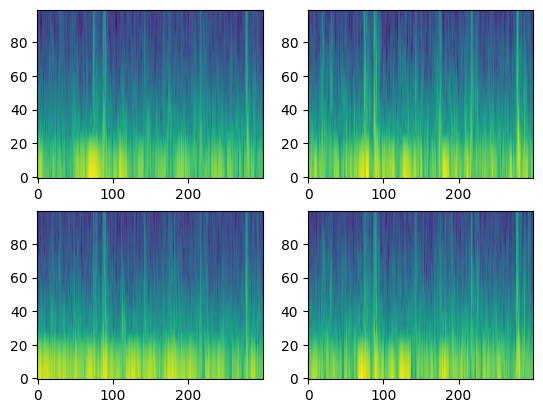

In [4]:
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 300

import librosa

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

def spg_from_eeg(eeg, display=False):
    n_mels = IMAGE_HEIGHT  # number of frequency bands
    n_windows = IMAGE_WIDTH  # number of windows
    hop_length = len(eeg) // IMAGE_WIDTH  # window hop/shift step size
    win_length = 2 * hop_length  # window size

    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((n_mels, n_windows, 4), dtype='float32')
    
    for i in range(4):
        COLS = FEATS[i]
        for j in range(4):  # 5 columns
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[j]].values - eeg[COLS[j + 1]].values

            # FILL NANS
            x = np.nan_to_num(x, nan=0.0)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=hop_length,
                  n_fft=1024, n_mels=n_mels, fmin=0, fmax=20, win_length=win_length)
            
            # LOG TRANSFORM
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)

            img[:, :, i] += mel_spec_db[:, :n_windows]
                
        # STANDARDIZE
        img[:, :, i] = img[:, :, i] - img[:, :, i].mean()
        img[:, :, i] = img[:, :, i] / (img[:, :, i].std() + 1e-6)

        if display:
            plt.subplot(2, 2, i + 1)
            plt.imshow(img[:, :, i], aspect='auto', origin='lower')
    
    return img

spg_from_eeg(eeg_window(train_df.iloc[0]), display=True).shape

In [5]:
import albumentations as albu

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, test_mode=False, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.test_mode = test_mode
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Denotes the number of batches per epoch"""
        m, r = divmod(len(self.data), self.batch_size)
        return m + (1 if r > 0 else 0)

    def __getitem__(self, i):
        """Generate one batch of data"""
        indices = self.indices[(i * self.batch_size):((i + 1) * self.batch_size)]
        X, y = self.__data_generation(indices)
        if self.augment:
            X = self.__augment_batch(X) 
        return X, y
    
    def __data_generation(self, indices):
        window_left = 150 - IMAGE_WIDTH // 2
        window_right = 150 + IMAGE_WIDTH // 2
        X = np.zeros((len(indices), IMAGE_HEIGHT, window_right - window_left, 4), dtype='float32')
        y = np.zeros((len(indices), 6), dtype='float32')

        for i_batch, i_row in enumerate(indices):
            row = self.data.iloc[i_row]

            spg = spg_window(row, train=not self.test_mode).values.T

            for j in range(4):
                img = spg[(j * 100):((j + 1) * 100), window_left:window_right]
                
                img = np.nan_to_num(img, nan=0.0)
                
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                img = img - img.mean()
                img = img / (img.std() + 1e-6)
                
                X[i_batch, :, :, j] = img[:, :]

            # X[i_batch, :, :, 4:] = spg_from_eeg(eeg_window(row))

            if not self.test_mode:
                y[i_batch, :] = row[TARGETS]

        return X, y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            #albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

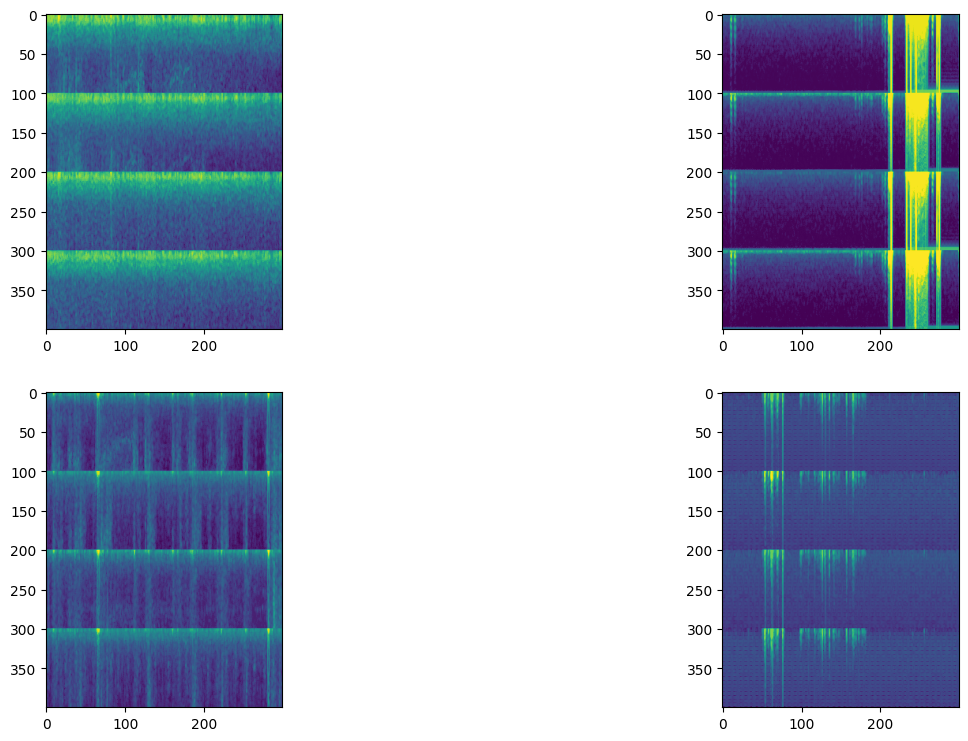

In [6]:
gen = DataGenerator(train_df, shuffle=True)

ROWS = 2
COLS = 2
BATCHES = 1

for i, (X, y) in enumerate(gen):
    plt.figure(figsize=(16, 9))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j * COLS + k + 1)
            t = y[j * COLS + k]
            img_spg = np.concatenate([X[j * COLS + k, :, :, a] for a in range(4)], axis=0)
            # img_eeg = np.concatenate([X[j * COLS + k, :, :, a] for a in range(4, 8)], axis=0)
            # img = np.concatenate([img_spg, img_eeg], axis=1)
            plt.imshow(img_spg)
    plt.show()
    if i == BATCHES - 1:
        break

In [7]:
def build_model():
    base_model = keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=None)

    inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 4))

    x = keras.layers.Concatenate(axis=1)([inputs[:, :, :, i:(i + 1)] for i in range(0, 4)])
    # x2 = keras.layers.Concatenate(axis=1)([inputs[:, :, :, i:(i + 1)] for i in range(4, 8)])
    # x = keras.layers.Concatenate(axis=2)([x1, x2])
    x = keras.layers.Concatenate(axis=3)([x, x, x])

    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(loss=keras.losses.KLDivergence(), optimizer=keras.optimizers.Adam(learning_rate=1e-3))

    return model

In [8]:
from sklearn.model_selection import GroupKFold

N_EPOCHS = 4

out_of_folds_predicts = []
out_of_folds_labels = []

group_k_fold = GroupKFold(n_splits=5)
for i, (train_indices, valid_indices) in enumerate(group_k_fold.split(train_df, groups=train_df.patient_id)):
    print(f'{"_" * 30} Fold {i} {"_" * 30}')

    train_data_gen = DataGenerator(train_df.iloc[train_indices], shuffle=True)
    valid_data_gen = DataGenerator(train_df.iloc[valid_indices], shuffle=False)

    model = build_model()
    model.fit(train_data_gen, validation_data=valid_data_gen, epochs=N_EPOCHS, verbose=1)
    model.save_weights(f'model_en0_f{i}.weights.h5')

    out_of_folds_predicts.append(model.predict(valid_data_gen))
    out_of_folds_labels.append(train_df.iloc[valid_indices][TARGETS].values)

out_of_folds_predicts = np.concatenate(out_of_folds_predicts)
out_of_folds_labels = np.concatenate(out_of_folds_labels)

______________________________ Fold 0 ______________________________


2024-02-21 07:28:34.560215: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 07:28:34.644786: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 07:28:34.644984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/4


2024-02-21 07:29:05.888212: I external/local_xla/xla/service/service.cc:168] XLA service 0x1aede1900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 07:29:05.888238: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-02-21 07:29:06.548508: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-21 07:29:09.786305: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-21 07:29:13.600139: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  2/428 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - loss: 1.2663   

I0000 00:00:1708500584.166722    5039 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/428 ━━━━━━━━━━━━━━━━━━━━ 291s 522ms/step - loss: 0.8621 - val_loss: 1.4298
Epoch 2/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - loss: 0.5615 - val_loss: 0.8734
Epoch 3/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - loss: 0.4870 - val_loss: 0.8919
Epoch 4/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - loss: 0.4113 - val_loss: 0.7869
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step
______________________________ Fold 1 ______________________________
Epoch 1/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 98s 120ms/step - loss: 0.8773 - val_loss: 1.8453
Epoch 2/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - loss: 0.5674 - val_loss: 0.8034
Epoch 3/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - loss: 0.4886 - val_loss: 0.8028
Epoch 4/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - loss: 0.4295 - val_loss: 0.7963
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step
______________________________ Fold 2 ______________________________
Epoch 1/4
428/428 ━━━━━━━━━━━━━━━━━━━━ 98s 124ms/step - loss: 0.8601 - val_loss: 1.3513

In [9]:
from kaggle_kl_div import score

out_of_folds_predicts_df = pd.DataFrame(out_of_folds_predicts.copy())
out_of_folds_predicts_df['id'] = np.arange(len(out_of_folds_predicts))

out_of_folds_labels_df = pd.DataFrame(out_of_folds_labels.copy())
out_of_folds_labels_df['id'] = np.arange(len(out_of_folds_labels))

score(solution=out_of_folds_labels_df, submission=out_of_folds_predicts_df, row_id_column_name='id')


0.7831753913777949

N_EPOCHS = 4, SPG only, 400 x 300 (600s): 5-fold CV=0.8692954482170927

N_EPOCHS = 4, SPG only, 400 x 60 (120s): 5-fold CV=0.8313863444779818